# PCA for NSL-KDD

Dimensionality reduction pipeline that feeds later anomaly detection steps.

## Imports and plotting defaults

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

DATA_DIR = Path('../data')
RANDOM_STATE = 42

## Load preprocessed datasets
Use the normalized tables from the preprocessing notebook as the starting point.

In [7]:
train_df = pd.read_csv(DATA_DIR / 'preproc_kdd_train.csv')
test_df = pd.read_csv(DATA_DIR / 'preproc_kdd_test.csv')

print(f'Train shape: {train_df.shape} | Test shape: {test_df.shape}')
print('Train attack distribution (top 5):')
print(train_df['attack_type'].value_counts().head())
print('Test attack distribution (top 5):')
print(test_df['attack_type'].value_counts().head())

train_df.head()

Train shape: (125973, 28) | Test shape: (22544, 28)
Train attack distribution (top 5):
attack_type
normal       67343
neptune      41214
satan         3633
ipsweep       3599
portsweep     2931
Name: count, dtype: int64
Test attack distribution (top 5):
attack_type
normal          9711
neptune         4657
guess_passwd    1231
mscan            996
warezmaster      944
Name: count, dtype: int64


,duration,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,protocol_tcp,protocol_udp,attack_type
0,-0.221617,-0.728254,0.782064,0.995517,-0.869111,-0.089486,-0.007736,-0.095076,-0.027023,0,...,1.00,0.00,0.00,0.17,0.03,0.17,0.00,1,0,normal
1,-0.221617,-0.881565,0.782064,0.590429,-0.869111,-0.089486,-0.007736,-0.095076,-0.027023,0,...,0.08,0.15,0.00,0.00,0.60,0.88,0.00,0,1,normal
2,-0.221617,0.190812,-0.813914,-1.082990,-0.869111,-0.089486,-0.007736,-0.095076,-0.027023,0,...,0.05,0.07,0.00,0.10,0.05,0.00,0.00,1,0,neptune
3,-0.221617,1.323938,0.782064,0.744881,1.668642,-0.089486,-0.007736,-0.095076,-0.027023,1,...,1.00,0.00,0.00,1.00,0.00,0.03,0.04,1,0,normal
4,-0.221617,1.323938,0.782064,0.693670,0.833560,-0.089486,-0.007736,-0.095076,-0.027023,1,...,1.00,0.00,0.09,1.00,0.00,0.00,0.00,1,0,normal


## Feature scaling & label prep
Re-apply `StandardScaler` so PCA sees zero-mean/unit-variance features.

In [8]:
feature_cols = [col for col in train_df.columns if col != 'attack_type']

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = (train_df['attack_type'] != 'normal').astype(int)
y_test = (test_df['attack_type'] != 'normal').astype(int)

print(f'Scaled feature matrix shape (train/test): {X_train.shape} / {X_test.shape}')
print(f'Attack rate train/test: {y_train.mean():.2%} / {y_test.mean():.2%}')

Scaled feature matrix shape (train/test): (125973, 27) / (22544, 27)
Attack rate train/test: 46.54% / 56.92%


## PCA variance analysis
Fit a full PCA to understand the cumulative variance curve and choose the 95% mark.

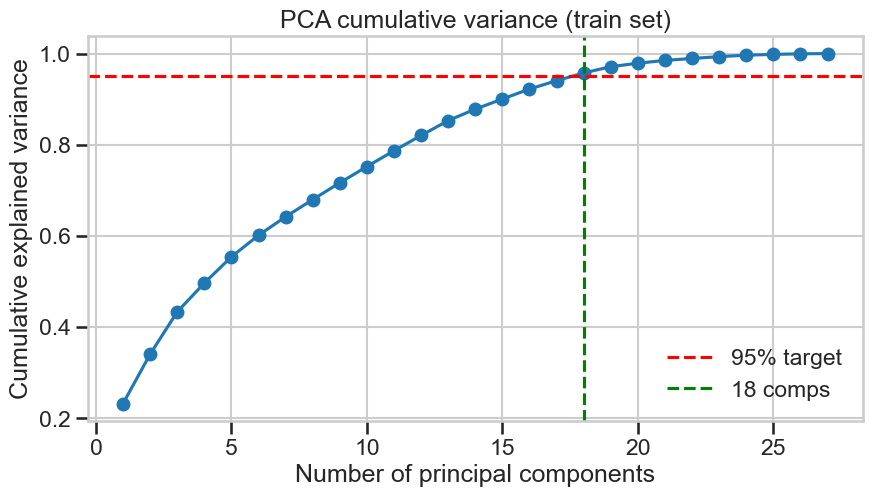

Components needed for >=95% variance: 18


In [9]:
pca_full = PCA().fit(X_train)
explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)
n_components_95 = int(np.argmax(cum_explained >= 0.95) + 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(cum_explained) + 1), cum_explained, marker='o')
ax.axhline(0.95, color='r', linestyle='--', label='95% target')
ax.axvline(n_components_95, color='g', linestyle='--', label=f'{n_components_95} comps')
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PCA cumulative variance (train set)')
ax.legend()
plt.show()

print(f'Components needed for >=95% variance: {n_components_95}')

## Transform & save PCA datasets
Project both splits into PCA space and persist them for downstream modeling.

In [10]:
pca = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

pca_columns = [f'pc{i:02d}' for i in range(1, X_train_pca.shape[1] + 1)]
train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
train_pca_df['attack_flag'] = y_train.to_numpy()

test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)
test_pca_df['attack_flag'] = y_test.to_numpy()

train_path = DATA_DIR / 'PCA-nsl_kdd_train.csv'
test_path = DATA_DIR / 'PCA-nsl_kdd_test.csv'
train_pca_df.to_csv(train_path, index=False)
test_pca_df.to_csv(test_path, index=False)

print(f'Saved PCA train set -> {train_path} ({train_pca_df.shape})')
print(f'Saved PCA test set  -> {test_path} ({test_pca_df.shape})')

Saved PCA train set -> ../data/PCA-nsl_kdd_train.csv ((125973, 19))
Saved PCA test set  -> ../data/PCA-nsl_kdd_test.csv ((22544, 19))
